# Procesamiento de imágenes usando joblib
###### Sebastián Córdoba

In [1]:
import matplotlib.pyplot as plt
import os
import requests
from io import BytesIO
import PIL
from PIL import Image
from PIL import Image, UnidentifiedImageError
import urllib.request

## 1. Cargar las imágenes desde el archivo .txt

In [2]:
# Leer los URLs desde el archivo 20_images.txt
with open('20_images.txt', 'r') as f:
    urls = f.read().splitlines()
urls = [url.strip() for url in urls]

In [3]:
images = []
urls_n = []
for url in urls:
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        images.append(img)
        urls_n.append(url)
    except UnidentifiedImageError:
        pass

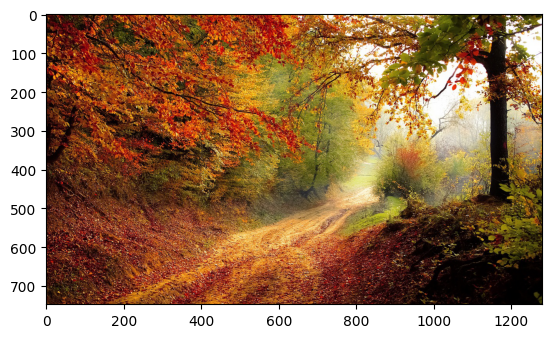

In [4]:
plt.imshow(images[21])

## 2. Transformar imágenes a vectores

In [5]:
import numpy as np

In [6]:
from joblib import Parallel, delayed

In [7]:
image_arrays = Parallel(n_jobs= -1)(delayed(np.array)(image) for image in images)

In [8]:
len(image_arrays)

37

## 3. Obtener el color principal o promedio de las imagenes

In [9]:
colores_principales = Parallel(n_jobs=-1)(delayed(np.mean)(imagen, axis=(0,1)) for imagen in image_arrays)

## 4. Cambiar el color de la imagen

In [10]:
def apagar_color_aleatorio(img_array):
  try:
    n = np.random.randint(0,3)
    img = img_array.copy()
    img[:, :, n] = 0
    return img
  except:
    return img_array

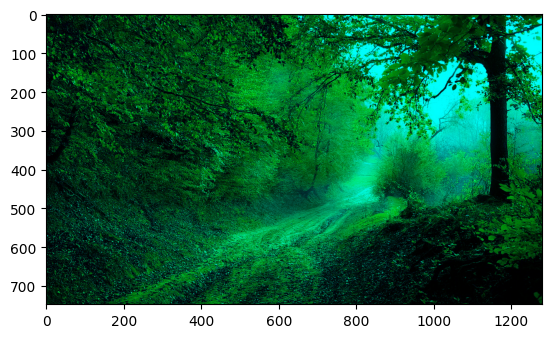

In [11]:
plt.imshow(apagar_color_aleatorio(image_arrays[21]))

In [12]:
# Generar nuevas imágenes con los colores ya cambiados
image_arrays_n = Parallel(n_jobs=-1)(delayed(apagar_color_aleatorio)(image) for image in image_arrays)

In [13]:
# Calcular nuevos colores principales
colores_principales_n = Parallel(n_jobs=-1)(delayed(np.mean)(imagen, axis=(0,1)) for imagen in image_arrays_n)

## 5. Generar DataFrame que contenga link, color principal y nuevo color

In [14]:
import pandas as pd

In [15]:
df = pd.DataFrame({'LINK': urls_n,
                   'COLOR_PRINCIPAL': colores_principales,
                   'COLOR_PRINCIPAL_NUEVO': colores_principales_n})

In [16]:
df.head()

,LINK,COLOR_PRINCIPAL,COLOR_PRINCIPAL_NUEVO
0,https://i.ytimg.com/vi/bDPkImgNs8Y/maxresdefau...,"[85.40168077256945, 64.06505533854167, 57.1640...","[85.40168077256945, 64.06505533854167, 0.0]"
1,https://e00-marca.uecdn.es/albumes/2014/11/18/...,"[184.90649350649352, 153.63449896812656, 149.9...","[0.0, 153.63449896812656, 149.97998165558357]"
2,https://hips.hearstapps.com/hmg-prod.s3.amazon...,"[236.1305242085661, 123.82851652700187, 57.645...","[236.1305242085661, 123.82851652700187, 0.0]"
3,https://static.wikia.nocookie.net/fairytail/im...,"[140.5216600916942, 169.93055762874508, 228.39...","[0.0, 169.93055762874508, 228.399650815652]"
4,https://static.wikia.nocookie.net/doblaje/imag...,"[154.43675533333334, 121.167646, 80.36239]","[154.43675533333334, 0.0, 80.36239]"


## 6. Agregar columna que contenga la diferencia del primer color con el segundo

In [17]:
def calcular_diferencia(x):
    return x['COLOR_PRINCIPAL'] - x['COLOR_PRINCIPAL_NUEVO']

In [18]:
df['DIFF_COLOR'] = Parallel(n_jobs=-1)(delayed(calcular_diferencia)(row) for _, row in df.iterrows())

In [19]:
df.head()

,LINK,COLOR_PRINCIPAL,COLOR_PRINCIPAL_NUEVO,DIFF_COLOR
0,https://i.ytimg.com/vi/bDPkImgNs8Y/maxresdefau...,"[85.40168077256945, 64.06505533854167, 57.1640...","[85.40168077256945, 64.06505533854167, 0.0]","[0.0, 0.0, 57.16406141493056]"
1,https://e00-marca.uecdn.es/albumes/2014/11/18/...,"[184.90649350649352, 153.63449896812656, 149.9...","[0.0, 153.63449896812656, 149.97998165558357]","[184.90649350649352, 0.0, 0.0]"
2,https://hips.hearstapps.com/hmg-prod.s3.amazon...,"[236.1305242085661, 123.82851652700187, 57.645...","[236.1305242085661, 123.82851652700187, 0.0]","[0.0, 0.0, 57.645935288640594]"
3,https://static.wikia.nocookie.net/fairytail/im...,"[140.5216600916942, 169.93055762874508, 228.39...","[0.0, 169.93055762874508, 228.399650815652]","[140.5216600916942, 0.0, 0.0]"
4,https://static.wikia.nocookie.net/doblaje/imag...,"[154.43675533333334, 121.167646, 80.36239]","[154.43675533333334, 0.0, 80.36239]","[0.0, 121.167646, 0.0]"
